In [2]:
# Set up parameters for image generation
width=256
height=256


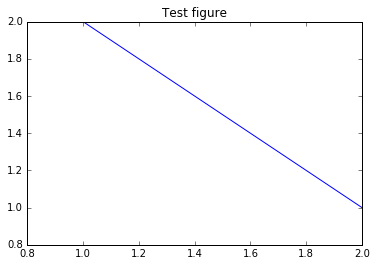

In [8]:
# plotting

from matplotlib import pyplot as plt
%matplotlib inline
fig = plt.figure()
plt.title("Test figure")
plt.plot([1, 2], [2, 1])

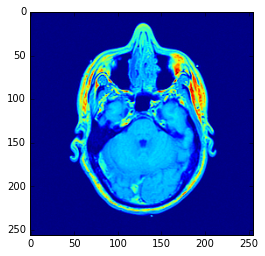

In [17]:
# Import an image!
import matplotlib.image as mpimg
img=mpimg.imread('../../data/fmri/mri-test1.png')
plt.imshow(img)

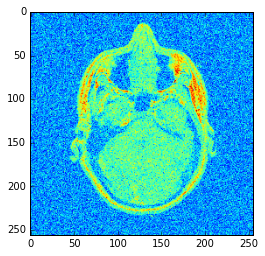

In [49]:
# Add noise to it
import numpy as np
noise = np.random.normal(size=img.shape, scale=0.1)
plt.imshow(img + noise)

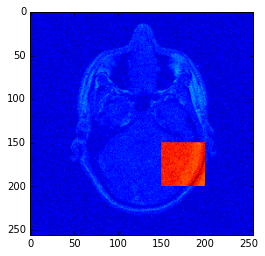

In [55]:
# OK, let us now use this idea to create two types of images.
positive_img= img
positive_img[150:200,150:200] += 0.01
plt.imshow(positive_img)
plt.imshow(positive_img + noise)